# Library Settings

In [32]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from obspy.signal.invsim import cosine_taper
from obspy.signal.filter import highpass
from obspy.signal.trigger import classic_sta_lta, trigger_onset

# Data Path Settings

## Training Data

We've used Lunar\S12_GradeA dataset for the training.

In [33]:
train_data_path = './data/lunar/training/data/S12_GradeA/'
catalog_file_path = './data/lunar/training/catalogs/apollo12_catalog_GradeA_final.csv'
catalog_df = pd.read_csv(catalog_file_path)

## Test Data

To confirm our model worthly finds the trigger of the earthquake, we've used Lunar\S12_GradeB (and other directories).

In [34]:
test_data_path = './data/lunar/training/data/S12_GradeB/'

# Data Extraction

## Extracting Small Segments from Training Data

In this function, we use 'time_rel(sec)' and 'velocity(m/s)' in .csv file. For more accurate & faster model training, only 100,000 adjacent measurement data points around the correct earthquake occurrence time are used for training.

In [58]:
def extract(train_data_path, catalog_df):
    X_data = []
    y_data = []

    for index, row in catalog_df.iterrows():
        fileName = row['filename']
        ansTime = row['time_rel(sec)']
        path = os.path.join(train_data_path, f"{fileName}.csv")

        if os.path.exists(path):
            data = pd.read_csv(path)
            ampl = np.abs(data['velocity(m/s)'].values)
            ansTime_idx = int(ansTime * (len(ampl) / 86400))

            if ansTime_idx < 20000:
                ampl = ampl[0:100000]
            elif len(ampl) - ansTime_idx < 80000:
                ansTime_idx -= len(ampl) - 100000
                ampl = ampl[len(ampl)-100000:len(ampl)]
            else:
                ampl = ampl[ansTime_idx-20000:ansTime_idx+80000]
                ansTime_idx = 20000

            ampl = ampl[::10]
            X_data.append(ampl)
            y_data.append(ansTime_idx)


    X_data = np.array(X_data)
    y_data = np.array(y_data)
    return X_data, y_data

## Save X(Time Series Data) and Y(Answer Data)

In [36]:
X_saved, y_saved = extract(train_data_path, catalog_df)
y_saved = y_saved // 10

In [37]:
X = X_saved
y = y_saved

In [38]:
print(X)
print(y)

[[3.51000000e-10 1.04000000e-10 8.15000000e-11 ... 2.77000000e-11
  2.45000000e-11 6.67000000e-11]
 [1.28000000e-10 3.07000000e-10 3.71000000e-10 ... 1.99000000e-10
  1.99000000e-10 2.54000000e-10]
 [3.90000000e-10 4.36000000e-10 1.41000000e-10 ... 1.75000000e-10
  2.36000000e-10 1.67000000e-10]
 ...
 [6.08202886e-11 2.80527970e-10 3.23802918e-10 ... 3.16153921e-10
  9.71414576e-11 9.04323963e-11]
 [2.44496342e-10 2.04967739e-11 1.56310447e-10 ... 1.29428379e-10
  5.17166740e-10 2.12060947e-10]
 [3.75158779e-10 1.39569843e-10 4.79569651e-10 ... 7.67234501e-13
  1.24489176e-11 4.47463138e-12]]
[2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000
 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 6024 2000 2000 2000
 2000 2000 2000 2000 2000 2000 2000 2000 5071 2000 2000 2000 2000 7654
 1748 2000 2000 2000 1749 2000 2000 2000 2000 2000 2000 2000 2000 8847
 2000 8449 2000 6422 2000 2000 2000 2000 2000  914 2000 2000 2000 2000
 2000 2000 2000 2000]


## Extracting Small Segments from Test Data

In this function, we pick the smaller data by sparsely sampling from the original ones.

In [59]:
def extractOfTest(test_data_path):
    t_data = []

    for fileName in os.listdir(test_data_path):
        if fileName.endswith('.csv'):
            path = os.path.join(test_data_path, fileName)
            data = pd.read_csv(path)
            ampl = np.abs(data['velocity(m/s)'].values)
            ampl = ampl[::10]
            t_data.append(ampl)

    return t_data

## Save T(Time Series Data for Confirmation)

In [40]:
test_saved = extractOfTest(train_data_path)

In [41]:
T = test_saved

In [42]:
print(T)

[array([6.15e-14, 8.59e-15, 2.90e-14, ..., 3.27e-14, 4.85e-14, 1.47e-14]), array([5.48e-15, 7.96e-16, 2.57e-15, ..., 3.12e-15, 1.28e-14, 3.47e-15]), array([2.82e-14, 6.44e-15, 1.14e-14, ..., 7.81e-15, 4.36e-14, 1.86e-14]), array([9.01642265e-15, 1.32366015e-15, 4.27261119e-15, ...,
       4.97613178e-15, 1.17339951e-14, 4.55561713e-15]), array([1.58356538e-16, 1.99477744e-17, 5.45991860e-17, ...,
       2.17333589e-15, 4.38996969e-15, 1.67617591e-15]), array([8.04257635e-16, 3.18994337e-17, 1.35117971e-16, ...,
       3.17487390e-16, 3.22659121e-18, 9.02340349e-16]), array([6.72797656e-16, 8.99854976e-17, 1.84636744e-16, ...,
       4.18052797e-16, 8.99725122e-16, 2.79695512e-17]), array([1.46215450e-15, 1.53203105e-16, 7.13590852e-16, ...,
       3.88414727e-16, 2.24229649e-15, 1.02868370e-15]), array([1.46215450e-15, 1.53203105e-16, 7.13590852e-16, ...,
       3.88414727e-16, 2.24229649e-15, 1.02868370e-15]), array([1.74335360e-16, 5.94966580e-17, 1.01529677e-16, ...,
       1.222827

# Data Processing for Training

## Functions

To use STA/LTA algorithm, it is important to preprocess the raw signal for the reduced noise. We've used a cosine taper to handle the boundary smoother, ans also applied a high-pass filter to remove high-frequency noise.

In [60]:
sampling_rate = 6.625
sta = 10
lta = 50
sWindow = int(sta * sampling_rate)
lWindow = int(lta * sampling_rate)


def preprocess_signal(data, sampling_rate):
    taper = cosine_taper(len(data), 0.1)
    data = data * taper
    filtered = highpass(data, freq=1.0, df=sampling_rate, corners=4, zerophase=True)
    return filtered

Our goal is to find the most certain evidence among as many potential earthquake occurrence times as possible. Therefore, we set the threshold value relatively low to secure a large number of candidate data points. Through the STA/LTA algorithm, we detected moments where the amplitude suddenly increases, and we also created a function to find the longest trigger segment for visualization through plotting.

In [61]:
def detectSTALTA(data, threshold_on=2.0, threshold_off=1.2):
    cft = classic_sta_lta(data, sWindow, lWindow)
    triggers = trigger_onset(cft, threshold_on, threshold_off)
    return cft, triggers


def findLongest(triggers):
    if len(triggers) == 0:
        return None
    durations = [(trigger[1] - trigger[0], trigger) for trigger in triggers]
    longest = max(durations, key=lambda k: k[0])[1]
    return longest

## Data Transformation

Here, we detect where can be the interval for the earthquake trigger using STA/LTA algorithm. For better model designing, we visualize the longest interval from the candidate triggers. The code plots the amplitude and STA/LTA characteristic function for the 6th(i = 5) time series data. (The index i = 5 can be changed)

Detected : [[2037 2379]
 [6293 6340]
 [6796 6943]
 [7208 7269]
 [7875 7953]
 [8332 8409]
 [8606 8778]
 [8839 8903]
 [9328 9404]
 [9475 9658]]
Longest : [2037 2379]


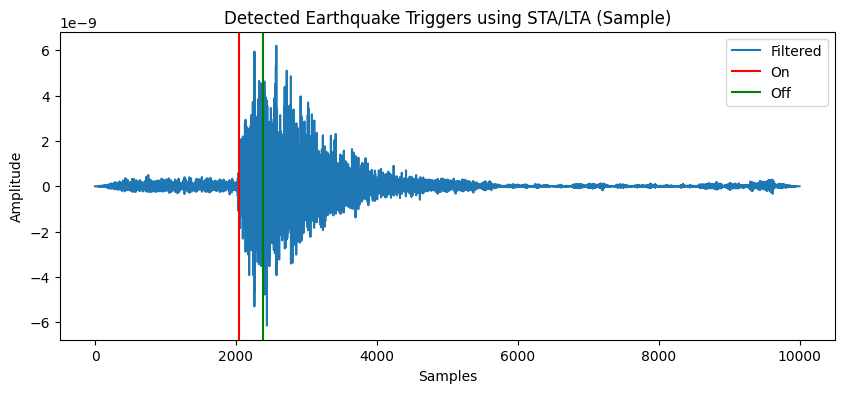

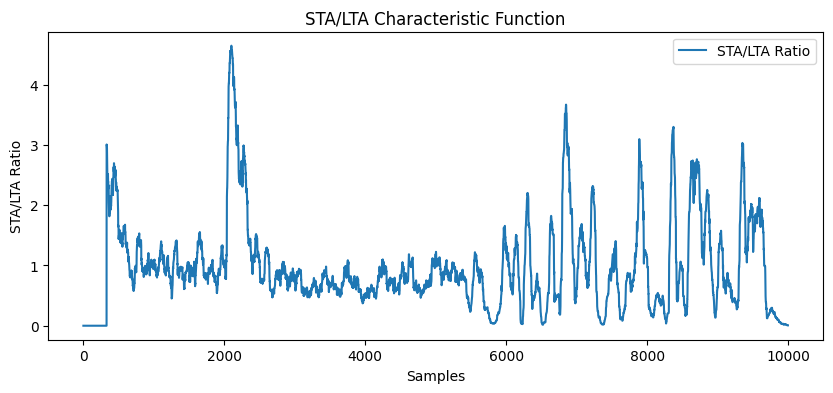

In [62]:
interval = []
charfunc = []

for i in range(len(X)):
    preprocessed_data = preprocess_signal(X[i], sampling_rate)
    cft, triggers = detectSTALTA(preprocessed_data)
    
    if len(triggers) > 0:
        triggers = np.array(triggers)
        triggers = triggers[triggers[:, 0] != 330]

    charfunc.append(cft)
    interval.append(triggers)
    trigger = findLongest(triggers)
    
    if i == 5:
        print(f'Detected : {triggers}')
        print(f'Longest : {trigger}')

        plt.figure(figsize=(10, 4))
        plt.plot(preprocessed_data, label='Filtered Data')
        if trigger is not None:
            plt.axvline(x=trigger[0], color='red', linestyle='-', label='On')
            plt.axvline(x=trigger[1], color='green', linestyle='-', label='Off')
        plt.title(f'Detected Earthquake Triggers using STA/LTA')
        plt.xlabel('Samples')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.show()

        plt.figure(figsize=(10, 4))
        plt.plot(cft, label='STA/LTA Ratio')
        plt.title('STA/LTA Characteristic Function')
        plt.xlabel('Samples')
        plt.ylabel('STA/LTA Ratio')
        plt.legend()
        plt.show()


Our model assigns three weights to each potential earthquake occurrence: the maximum amplitude within the segment, the maximum STA/LTA ratio, and the segment length (duration of the event that could be classified as an earthquake). To apply these to the model, we store the amplitude, STA/LTA ratio, and segment length for all possible earthquake occurrence segments in each time series data.

In [64]:
X_train = []
y_train = [0]*len(X)
for i in range(len(X)):
    large_tmp = []
    for x in interval[i]:
        tmp = [0,0,0]
        tmp[0] = np.max(X[i][x[0]:x[1]]) * 1e9
        tmp[1] = np.max(charfunc[i][x[0]:x[1]])
        tmp[2] = (x[1] - x[0]) / 100
        if y[i] in range(x[0]-500, x[1]):
            y_train[i] = tmp.copy()
        elif x[1] - x[0] < 150:
            continue
        large_tmp.append(tmp)
    X_train.append(large_tmp)

print(X_train)
print(y_train)
print(len(y_train))

ampl = []
ratio = []
dur = []
for group in X_train:
    ampl.extend([x[0] for x in group])
    ratio.extend([x[1] for x in group])
    dur.extend([x[2] for x in group])

[[[7.87, 4.834181510333762, 4.23]], [[4.2, 3.138114744385124, 4.34]], [[6.14, 3.909155481182367, 4.01]], [[5.386065455958148, 4.017196992596382, 3.01]], [[4.542430087973785, 3.9427300131657828, 2.48], [1.937204021404175, 2.228893002850956, 2.11]], [[13.27453534015848, 4.644308109551481, 3.42], [0.3001210344848557, 2.7612115071279324, 1.72], [1.4279094069383451, 2.1170139445447536, 1.83]], [[30.95898860762659, 4.664072020469148, 3.28]], [[16.720904768857668, 4.122557504081547, 4.1]], [[1.6419959774488682, 3.868730383118115, 6.08], [5.320810717363669, 4.474750997676633, 2.43]], [[0.654035075552538, 3.2804346288131514, 2.12], [3.9893334930214244, 3.934064315131407, 2.41]], [[3.218385048131596, 2.5887225699693164, 3.05], [0.6751750437622535, 4.786673572356637, 1.6]], [[5.325911455737198, 3.530002674868387, 3.6]], [[3.8883663471154026, 5.004446561293472, 5.7]], [[4.933840047708657, 4.099576353448657, 2.94]], [[4.707409579472935, 4.641383848704006, 2.39]], [[0.14774670992040348, 3.6861702101

# Model Training using Keras

## Getting Weights

We set the weights corresponding to amplitude, STA/LTA ratio, and segment length as a, b, and c, respectively. For a given time series, we know the possible earthquake occurrence candidates and the actual time when the earthquake occurred. From each of these, we can also obtain the amplitude, STA/LTA ratio, and segment length. We configured the weights so that the sum of the weighted values for these variables is maximized for the actual earthquake occurrence data.

In [65]:
X_input = np.column_stack((ampl, ratio, dur))
y_indices = []

for i, group in enumerate(X_train):
    for idx, val in enumerate(group):
        if np.allclose(val, y_train[i]):
            y_indices.append(idx)
            break

input_data = Input(shape=(3,))
dense1 = Dense(64, activation='relu')(input_data)
dropout1 = Dropout(0.05)(dense1)
dense2 = Dense(32, activation='relu')(dropout1)
dropout2 = Dropout(0.05)(dense2)
output = Dense(1, use_bias=False)(dropout2)

model = Model(inputs=input_data, outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')


def ranking_loss(y_true, y_pred):
    loss = 0
    start = 0
    for i, group in enumerate(X_train):
        end = start + len(group)
        group_preds = y_pred[start:end]
        correct_pred = group_preds[y_indices[i]]
        for j in range(len(group)):
            if j != y_indices[i]:
                loss += tf.maximum(0.0, 1.0 - (correct_pred - group_preds[j]))
        start = end
    return loss


model.fit(X_input, np.zeros(len(X_input)), epochs=100, verbose=2, batch_size=32)

weights = model.get_weights()
dense_weights = weights[0].flatten()
a, b, c = dense_weights[:3]
print(f"Learned parameters: a={a}, b={b}, c={c}")



Epoch 1/100
4/4 - 1s - 132ms/step - loss: 1.2888
Epoch 2/100
4/4 - 0s - 6ms/step - loss: 7.5455
Epoch 3/100
4/4 - 0s - 6ms/step - loss: 1.1900
Epoch 4/100
4/4 - 0s - 6ms/step - loss: 1.1977
Epoch 5/100
4/4 - 0s - 7ms/step - loss: 1.9005
Epoch 6/100
4/4 - 0s - 6ms/step - loss: 0.6649
Epoch 7/100
4/4 - 0s - 6ms/step - loss: 1.0446
Epoch 8/100
4/4 - 0s - 5ms/step - loss: 0.3885
Epoch 9/100
4/4 - 0s - 6ms/step - loss: 2.1456
Epoch 10/100
4/4 - 0s - 5ms/step - loss: 0.2829
Epoch 11/100
4/4 - 0s - 5ms/step - loss: 0.5887
Epoch 12/100
4/4 - 0s - 6ms/step - loss: 0.2047
Epoch 13/100
4/4 - 0s - 6ms/step - loss: 1.2895
Epoch 14/100
4/4 - 0s - 6ms/step - loss: 0.7190
Epoch 15/100
4/4 - 0s - 6ms/step - loss: 0.5154
Epoch 16/100
4/4 - 0s - 7ms/step - loss: 0.5013
Epoch 17/100
4/4 - 0s - 5ms/step - loss: 0.5333
Epoch 18/100
4/4 - 0s - 5ms/step - loss: 1.2838
Epoch 19/100
4/4 - 0s - 5ms/step - loss: 0.3571
Epoch 20/100
4/4 - 0s - 6ms/step - loss: 0.8797
Epoch 21/100
4/4 - 0s - 6ms/step - loss: 0.2530

In [74]:
a=0.22672614455223083
b=-0.029509663581848145
c=0.0457753948867321

We've applied the learned weights to the Lunar_S12_GradeA dataset, where the correct earthquake occurrences are known, for comparison. After identifying the candidate earthquake segments, we applied the weights to the detailed features, and the segment with the maximum weighted sum matched the actual earthquake occurrence in 72 out of 74 cases, resulting in approximately 97% accuracy.

In [68]:
right = 0
wrong = 0
for i in range(len(X)):
    ans = []
    Max = -1e9
    for x in X_train[i]:
        yo = a*x[0] + b*x[1] + c*x[2]
        yo = yo.astype(np.float32)
        if yo > Max:
            Max = yo
            ans = x
    print(ans, y_train[i])
    if ans == y_train[i]:
        right += 1
    else:
        wrong += 1

print(right, wrong)
print(f'accuracy : {right/len(X)*100}%')

[7.87, 4.834181510333762, 4.23] [7.87, 4.834181510333762, 4.23]
[4.2, 3.138114744385124, 4.34] [4.2, 3.138114744385124, 4.34]
[6.14, 3.909155481182367, 4.01] [6.14, 3.909155481182367, 4.01]
[5.386065455958148, 4.017196992596382, 3.01] [5.386065455958148, 4.017196992596382, 3.01]
[4.542430087973785, 3.9427300131657828, 2.48] [4.542430087973785, 3.9427300131657828, 2.48]
[13.27453534015848, 4.644308109551481, 3.42] [13.27453534015848, 4.644308109551481, 3.42]
[30.95898860762659, 4.664072020469148, 3.28] [30.95898860762659, 4.664072020469148, 3.28]
[16.720904768857668, 4.122557504081547, 4.1] [16.720904768857668, 4.122557504081547, 4.1]
[5.320810717363669, 4.474750997676633, 2.43] [5.320810717363669, 4.474750997676633, 2.43]
[3.9893334930214244, 3.934064315131407, 2.41] [3.9893334930214244, 3.934064315131407, 2.41]
[3.218385048131596, 2.5887225699693164, 3.05] [3.218385048131596, 2.5887225699693164, 3.05]
[5.325911455737198, 3.530002674868387, 3.6] [5.325911455737198, 3.530002674868387, 3

# Data Processing for Testing

## Data Transformation

For the preprocessing, we use the functions defined during the training process. All the raw time series data belonging to Lunar_S12_GradeB are saved in the list T.

Detected : [[  857   957]
 [ 1046  1201]
 [ 1242  1350]
 [ 1430  1545]
 [ 1768  1844]
 [ 2229  2359]
 [ 8582  8945]
 [11934 12015]
 [20773 20810]
 [27902 27967]
 [28770 28799]
 [29099 29142]
 [29834 29899]
 [30169 30254]
 [31022 31031]
 [31604 31648]
 [32637 32690]
 [34301 34335]
 [50773 50852]
 [52861 52972]
 [53515 53579]]
Longest : [8582 8945]


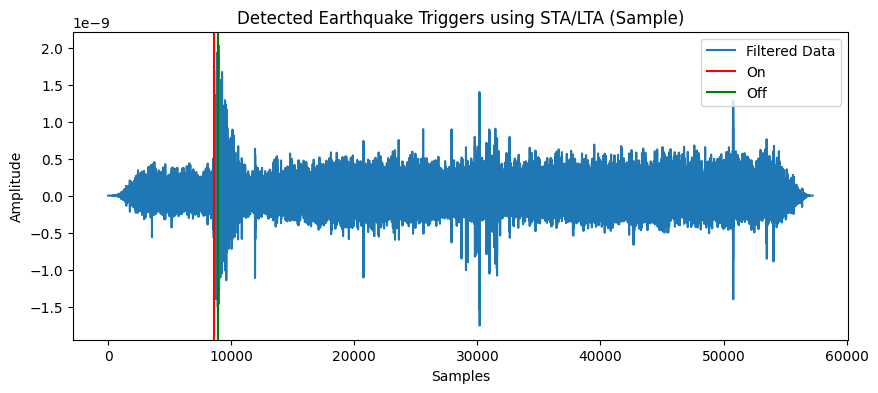

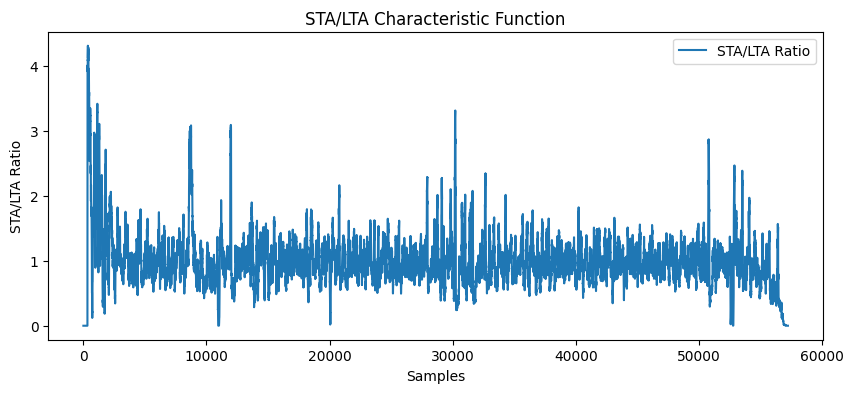

In [69]:
interval_t = []
charfunc_t = []

for i in range(len(T)):
    preprocessed_data = preprocess_signal(T[i], sampling_rate)
    cft, triggers = detectSTALTA(preprocessed_data)
    
    if len(triggers) > 0:
        triggers = np.array(triggers)
        triggers = triggers[triggers[:, 0] != 330]

    charfunc_t.append(cft)
    interval_t.append(triggers)
    trigger = findLongest(triggers)
    
    if i == 1:
        print(f'Detected : {triggers}')
        print(f'Longest : {trigger}')

        plt.figure(figsize=(10, 4))
        plt.plot(preprocessed_data, label='Filtered Data')
        if trigger is not None:
            plt.axvline(x=trigger[0], color='red', linestyle='-', label='On')
            plt.axvline(x=trigger[1], color='green', linestyle='-', label='Off')
        plt.title(f'Detected Earthquake Triggers using STA/LTA (Sample)')
        plt.xlabel('Samples')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.show()

        plt.figure(figsize=(10, 4))
        plt.plot(cft, label='STA/LTA Ratio')
        plt.title('STA/LTA Characteristic Function')
        plt.xlabel('Samples')
        plt.ylabel('STA/LTA Ratio')
        plt.legend()
        plt.show()


Similarly, this code abstracts three components(maximum amplitude, maximum STA/LTA ratio, duration) from each candidates.

In [70]:
T_train = []
for i in range(len(T)):
    large_tmp = []
    for x in interval_t[i]:
        tmp = [0,0,0,0]
        tmp[0] = np.max(T[i][x[0]:x[1]]) * 1e9
        tmp[1] = np.max(charfunc_t[i][x[0]:x[1]])
        tmp[2] = (x[1] - x[0]) / 100
        tmp[3] = [x[0], x[1]]
        if x[1] - x[0] < 150:
            continue
        large_tmp.append(tmp)
    T_train.append(large_tmp)

print(len(T_train))
print(len(T))

ampl = []
ratio = []
dur = []
for group in T_train:
    ampl.extend([x[0] for x in group])
    ratio.extend([x[1] for x in group])
    dur.extend([x[2] for x in group])

75
75


This code is additional but essential. To check every earthquake happened in one day (not the biggest one), a lower bound is needed to determine whether the weight-calculated value can be classified as an earthquake. This can be done by sorting the values calculated using the weights on the trained correct data in order, then setting the median as a threshold. You can think of it as, 'Any value higher than this can be considered an earthquake!'

In [71]:
ansValList = []
for ans in y_train:
    ansValList.append(a*ans[0]+b*ans[1]+c*ans[2])
ansValList.sort()
eq_bound = ansValList[int(len(y_train)*0.5)]
print(eq_bound)

0.9948345269053824


# Model Testing

Finally, here we predict one or multiple optimal earthquake occurrence times from the raw data in the test folder, which was not used for training. Similar code was used during the training process, and similarly, you can visualize the time series data for the desired indices. As you can see, it surprisingly detects every multiple earthquakes occurring on the same day with very high accuracy!

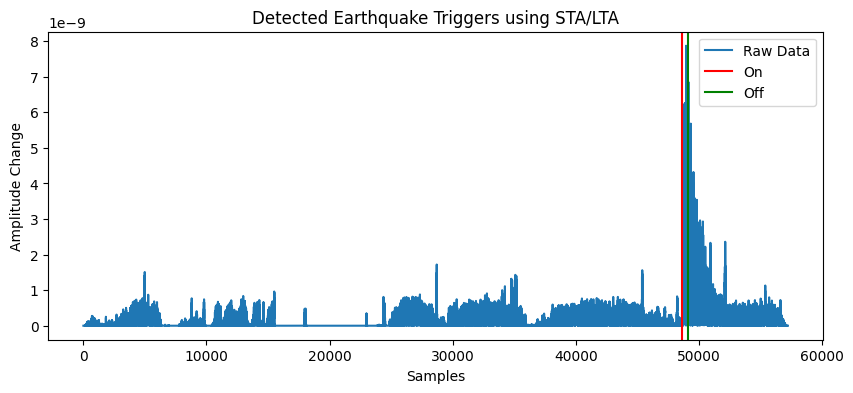

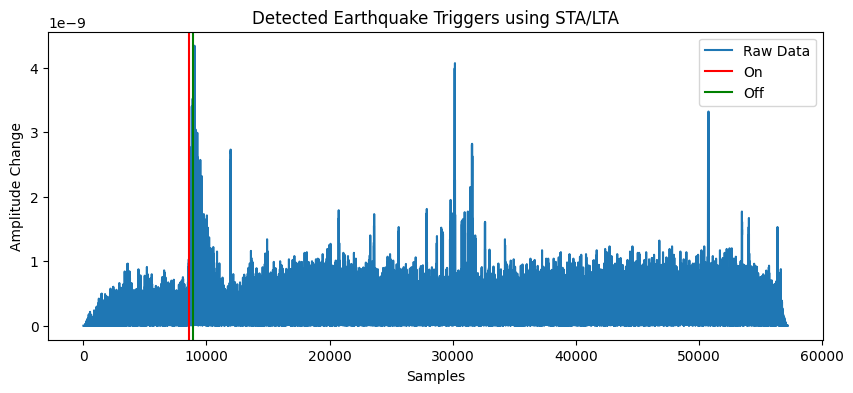

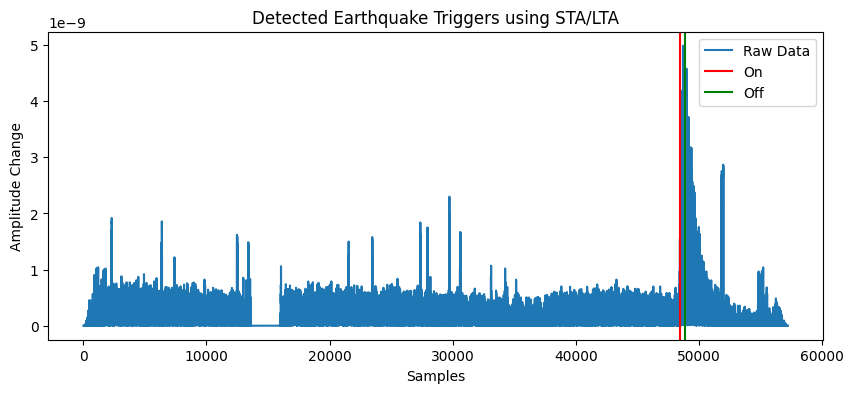

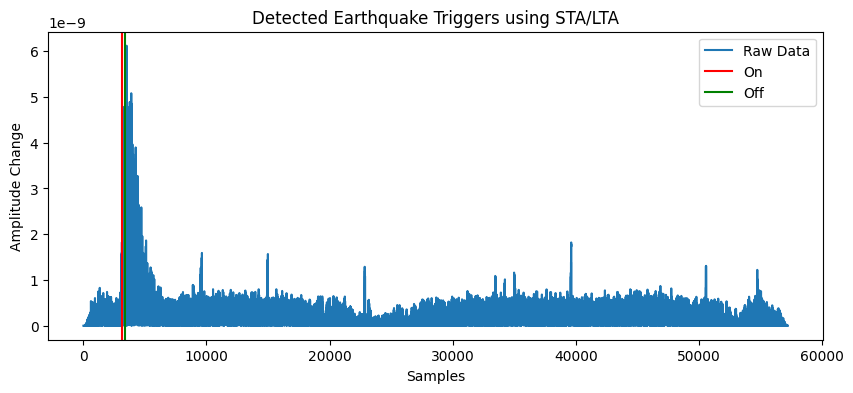

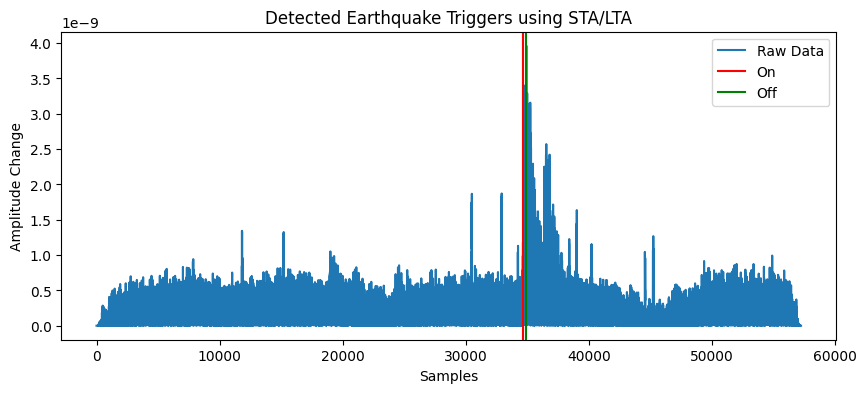

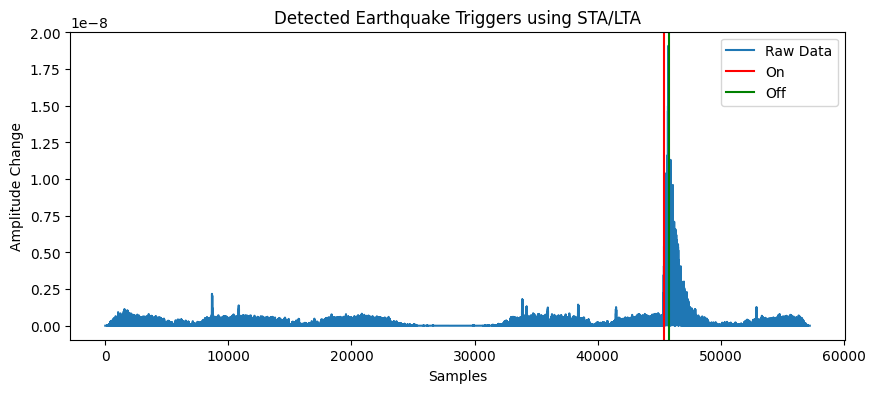

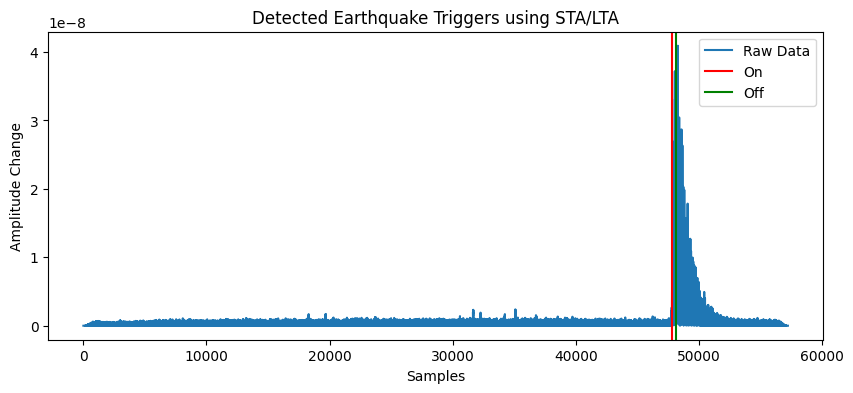

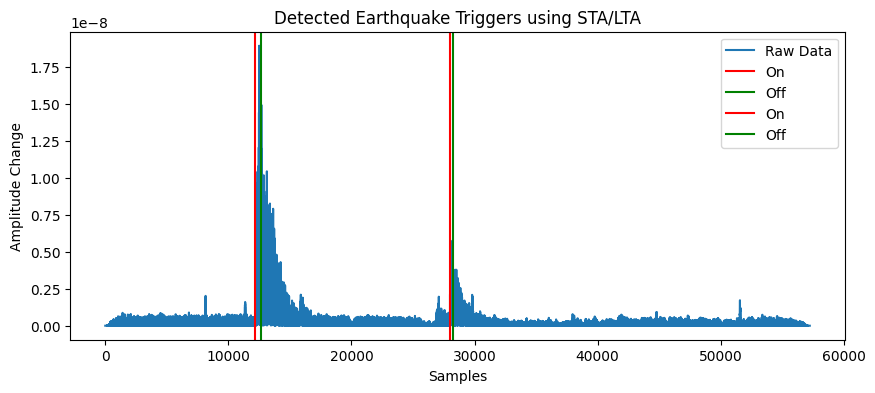

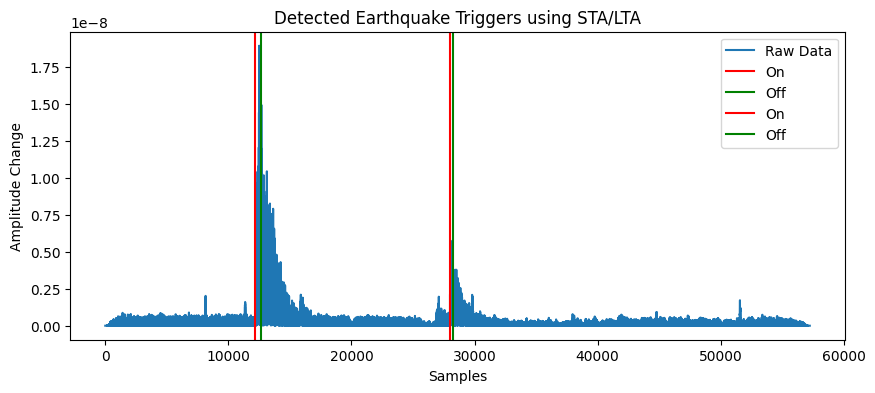

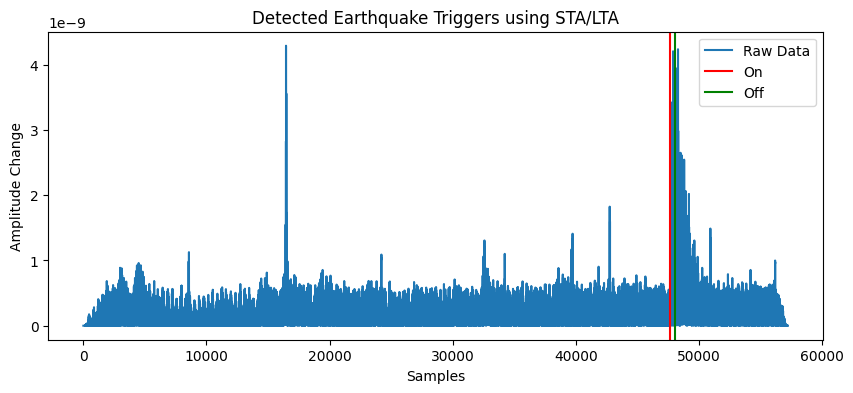

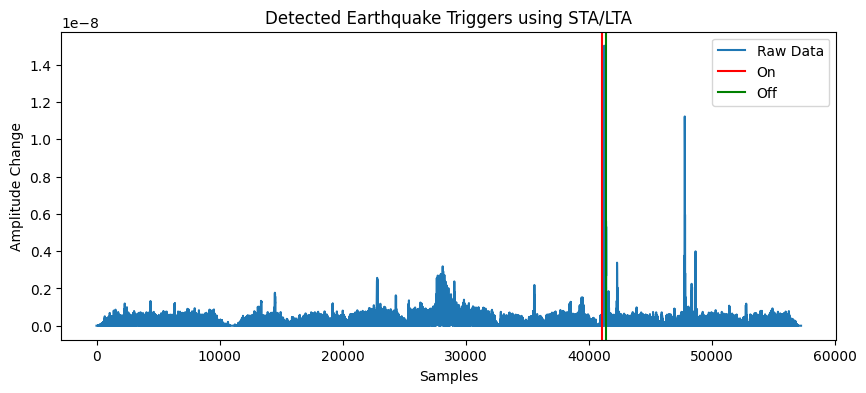

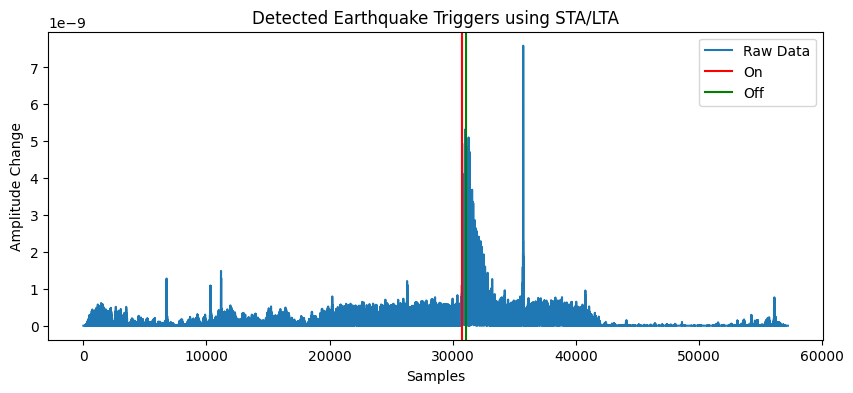

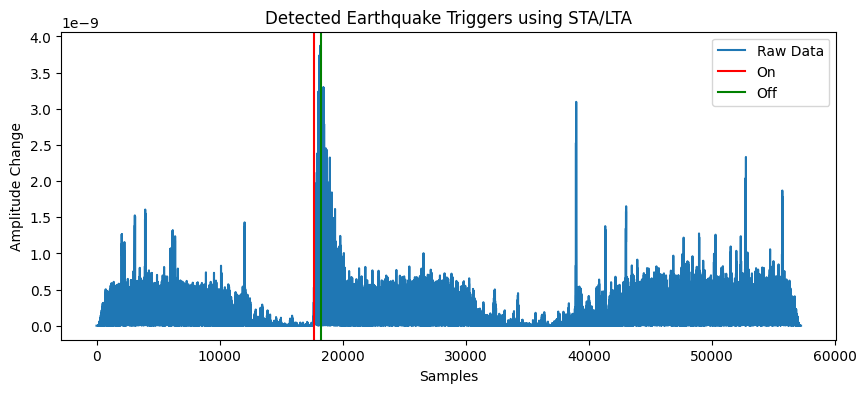

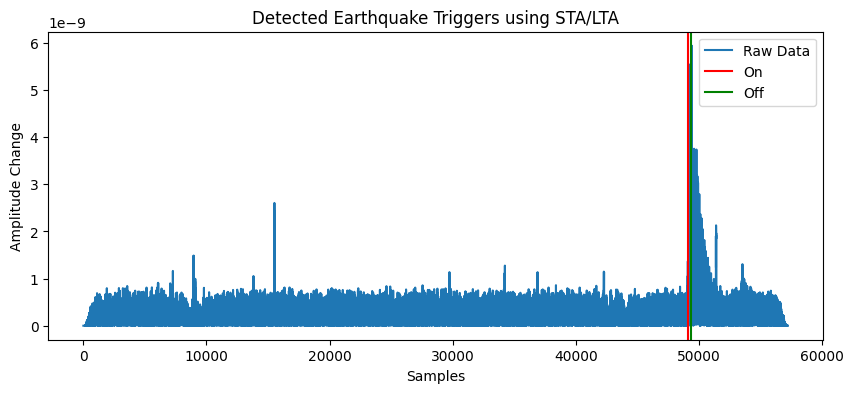

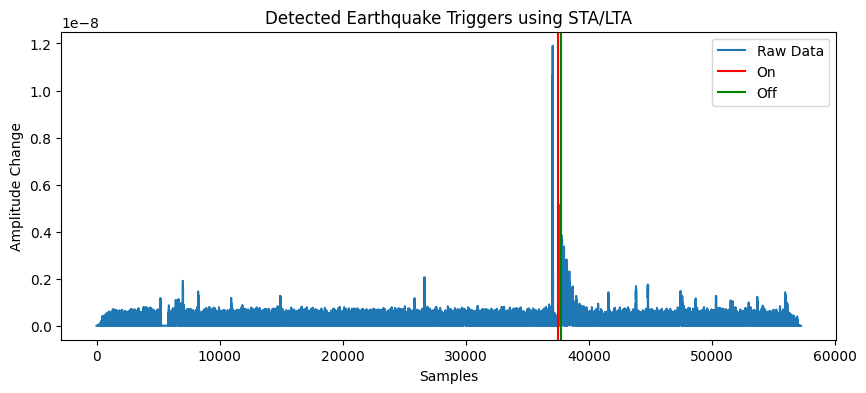

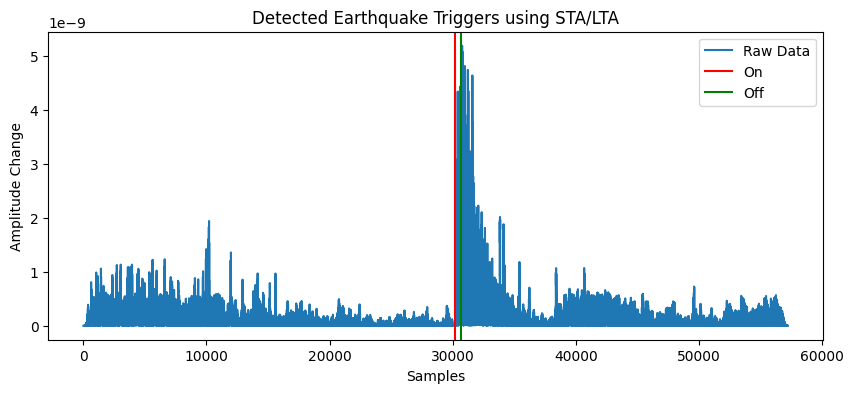

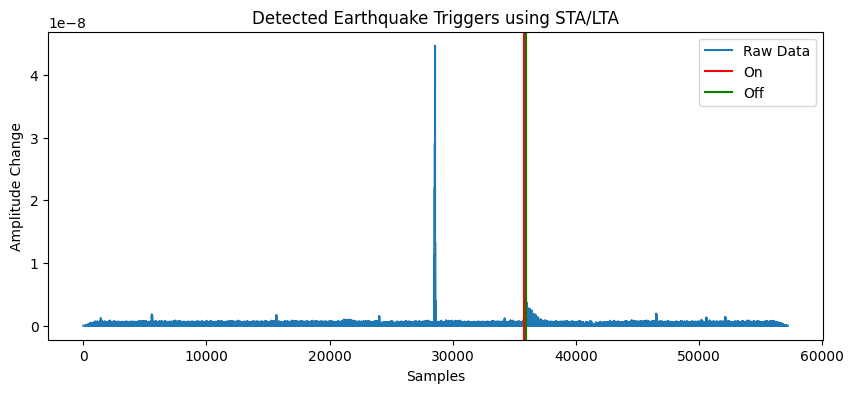

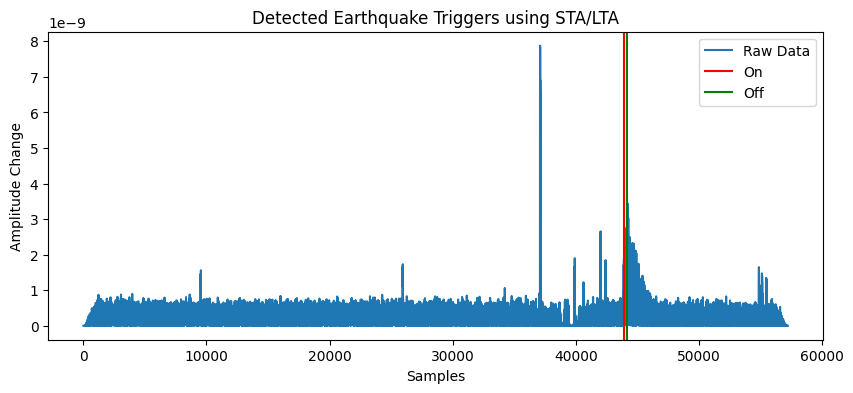

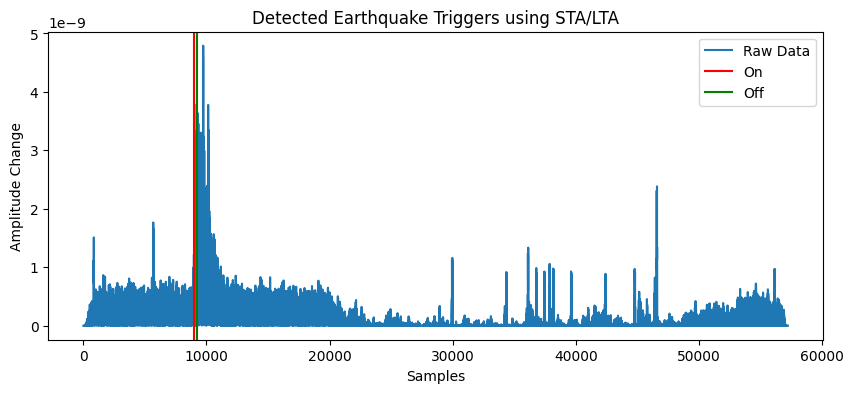

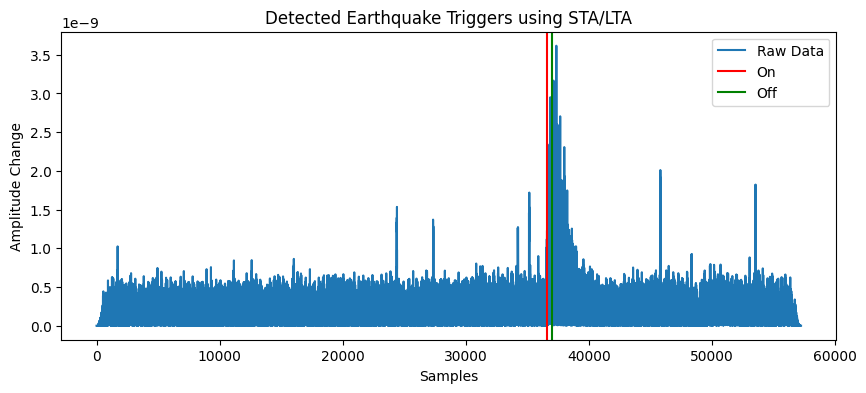

In [73]:
for i in range(len(T)):
    ans = []
    ansMax = []
    Max = -1e9

    for x in T_train[i]:
        yo = a*x[0] + b*x[1] + c*x[2]
        yo = yo.astype(np.float32)
        if yo > Max:
            Max = yo
            ansMax = x[3]
        if yo > eq_bound:
            ans.append(x[3])
    if ansMax not in ans:
        ans.append(ansMax)

    if i in range(20):
        plt.figure(figsize=(10, 4))
        plt.plot(T[i], label='Raw Data')
        
        for k in ans:
            plt.axvline(x=k[0], color='red', linestyle='-', label='On')
            plt.axvline(x=k[1], color='green', linestyle='-', label='Off')
        
        plt.title(f"Detected Earthquake Triggers using STA/LTA")
        plt.xlabel('Samples')
        plt.ylabel('Amplitude Change')
        plt.legend()
        plt.show()

